In [2]:
import pandas as pd
import numpy as np
import os 

DATA_PATH = '/home/jiez/TrajectoryPrediction/kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync'

IMU_COLUMN_NAMES = ['lat', 'lon', 'alt', 'roll', 'pitch', 'yaw', 'vn', 've', 'vf', 'vl', 'vu', 
                    'ax', 'ay', 'az', 'af', 'al', 'au', 'wx', 'wy', 'wz', 'wf', 'wl', 'wu',
                    'posacc', 'velacc', 'navstat', 'numsats', 'posmode', 'velmode', 'orimode']

def read_imu(path):
    df = pd.read_csv(path, header=None, sep=' ')
    df.columns = IMU_COLUMN_NAMES
    return df

def compute_great_circle_distance(lat1, lon1, lat2, lon2):
    
    delta_sigma = float(np.sin(lat1*np.pi/180)*np.sin(lat2*np.pi/180)+ \
                        np.cos(lat1*np.pi/180)*np.cos(lat2*np.pi/180)*np.cos(lon1*np.pi/180-lon2*np.pi/180))
    return 6371000.0 * np.arccos(np.clip(delta_sigma, -1, 1))

In [7]:
prev_imu_data = None
gps_distances = []
imu_distances = []
for frame in range(150):
    imu_data = read_imu((os.path.join(DATA_PATH, 'oxts/data/%010d.txt'%frame)))
    
    if prev_imu_data is not None:
        gps_distances += [compute_great_circle_distance(imu_data.lat, imu_data.lon, prev_imu_data.lat, prev_imu_data.lon)]
        imu_distances += [0.1*np.linalg.norm(imu_data[['vf','vl']])] # drive distance within 0.1s
    prev_imu_data = imu_data

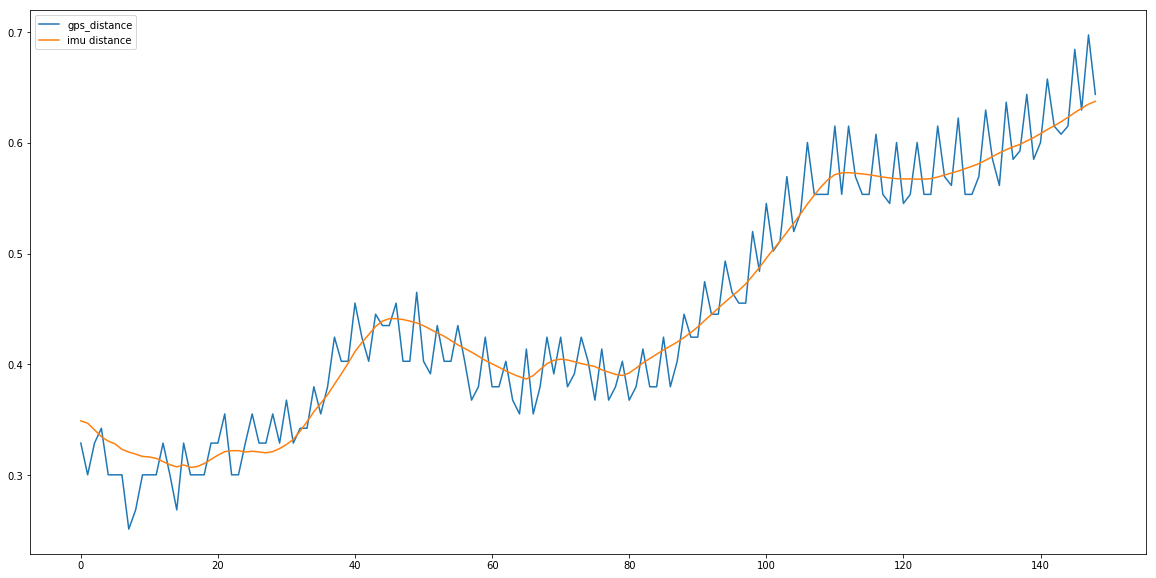

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(gps_distances, label='gps_distance')
plt.plot(imu_distances, label='imu distance')
plt.legend()
plt.show()

In [5]:
read_imu((os.path.join(DATA_PATH, 'oxts/data/%010d.txt'%0)))

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,wf,wl,wu,posacc,velacc,navstat,numsats,posmode,velmode,orimode
0,49.011213,8.422885,112.834923,0.022447,0.00001,-1.22191,-3.325632,1.138431,3.514768,0.037625,...,-0.017499,0.021393,0.14563,0.492294,0.068884,4,10,4,4,0


In [6]:
read_imu((os.path.join(DATA_PATH, 'oxts/data/%010d.txt'%1)))

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,wf,wl,wu,posacc,velacc,navstat,numsats,posmode,velmode,orimode
0,49.01121,8.422887,112.846901,0.022857,0.004342,-1.206077,-3.288107,1.166745,3.488639,0.054704,...,-0.004166,0.044282,0.139954,0.492294,0.068884,4,10,4,4,0


In [13]:
prev_imu_data = None
locations = []
for frame in range(150):
    imu_data = read_imu((os.path.join(DATA_PATH, 'oxts/data/%010d.txt'%frame)))
    
    if prev_imu_data is not None:
        # imu_distances += [0.1*np.linalg.norm(imu_data[['vf','vl']])] # drive distance within 0.1s
        displacement = 0.1*np.linalg.norm(imu_data[['vf','vl']])
        yaw_change = float(imu_data.yaw - prev_imu_data.yaw)
        for i in range(len(locations)):
            x0, y0 = locations[i]
            x1 = x0 * np.cos(yaw_change) + y0 * np.sin(yaw_change) - displacement
            y1 = -x0 * np.sin(yaw_change) + y0 * np.cos(yaw_change)
            locations[i] = np.array([x1, y1])   
    locations += [np.array([0, 0])]
    prev_imu_data = imu_data

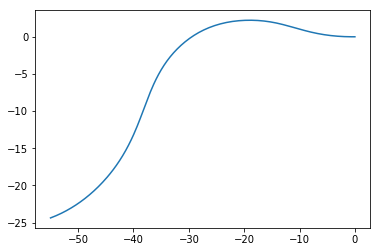

In [15]:
plt.plot(np.array(locations)[:, 0], np.array(locations)[:, 1])